In [19]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


In [ ]:
!conda install numba
!conda install cudatoolkit

In [ ]:
!pip install torch_snippets

In [1]:
import os
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import imgaug.augmenters as iaa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)

In [3]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [4]:
images = stems(f'/content/drive/MyDrive/gdsc-nu-ml-hackathon-bts-case-competition/train/imgs')
train_spl = images[:200]
val_spl = images[200:]

In [7]:
class SegData(Dataset):
    def __init__(self, split, aug=False):
        self.split = split
        self.aug = aug
    def __len__(self):
        return len(self.split)
    def __getitem__(self, ix):
        image = read(f'/content/drive/MyDrive/gdsc-nu-ml-hackathon-bts-case-competition/train/imgs/{self.split[ix]}.jpg', 1)
        mask = read(f'/content/drive/MyDrive/gdsc-nu-ml-hackathon-bts-case-competition/train/masks/{self.split[ix]}.png')
        if self.aug:
            image = diffusion4(image)
        mask = np.where(mask != 0, 1, mask)
        return image, mask
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [8]:
trn_ds = SegData(train_spl)
trn_aug = SegData(train_spl, aug=True)
train = torch.utils.data.ConcatDataset([trn_ds, trn_aug])

val_ds = SegData(val_spl)
trn_dl = DataLoader(train, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [11]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [12]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [13]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=2):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [14]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [15]:
import torch
import torch.nn as nn
import torchvision
resnet = torchvision.models.resnet.resnet50(pretrained=True)


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

model = UNetWithResnet50Encoder().cuda()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [17]:
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [18]:
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(1,3,576,768))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torch_summary-1.4.5-py3-none-any.whl (16 kB)
Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 64, 288, 384]        --
|    └─Conv2d: 2-1                            [-1, 64, 288, 384]        9,408
|    └─BatchNorm2d: 2-2                       [-1, 64, 288, 384]        128
|    └─ReLU: 2-3                              [-1, 64, 288, 384]        --
├─MaxPool2d: 1-2                              [-1, 64, 144, 192]        --
├─ModuleList: 1                               []                        --
|    └─Sequential: 2-4                        [-1, 256, 144, 192]       --
|    |    └─Bottleneck: 3-1                   [-1, 256, 144, 192]       75,008
|    |    └─Bottleneck: 3-2                   [-1, 256, 144, 192]       70,400
|    |    └─Bottleneck: 3-3                   [-1, 256, 144, 192]       70

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 64, 288, 384]        --
|    └─Conv2d: 2-1                            [-1, 64, 288, 384]        9,408
|    └─BatchNorm2d: 2-2                       [-1, 64, 288, 384]        128
|    └─ReLU: 2-3                              [-1, 64, 288, 384]        --
├─MaxPool2d: 1-2                              [-1, 64, 144, 192]        --
├─ModuleList: 1                               []                        --
|    └─Sequential: 2-4                        [-1, 256, 144, 192]       --
|    |    └─Bottleneck: 3-1                   [-1, 256, 144, 192]       75,008
|    |    └─Bottleneck: 3-2                   [-1, 256, 144, 192]       70,400
|    |    └─Bottleneck: 3-3                   [-1, 256, 144, 192]       70,400
|    └─Sequential: 2-5                        [-1, 512, 72, 96]         --
|    |    └─Bottleneck: 3-4                   [-1, 512, 72, 96]         379,392

In [19]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
%cd
%cd /content/drive/MyDrive
%mkdir vgg19_dd
%cd vgg19_dd
torch.save(model.state_dict(), 'model_scripted.pt')

optimizer = optim.Adam(model.parameters(), lr=1e-4)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)
     

EPOCH: 1.000  val_loss: 0.025  val_acc: 0.997  trn_acc: 0.987  trn_loss: 0.093  (372.87s - 7084.54s remaining)
EPOCH: 2.000  val_loss: 0.011  val_acc: 0.998  trn_acc: 0.998  trn_loss: 0.014  (737.86s - 6640.71s remaining)
EPOCH: 3.000  val_loss: 0.006  val_acc: 0.999  trn_acc: 0.999  trn_loss: 0.007  (1099.32s - 6229.48s remaining)
EPOCH: 4.000  val_loss: 0.004  val_acc: 0.999  trn_acc: 0.999  trn_loss: 0.005  (1462.81s - 5851.22s remaining)
EPOCH: 5.000  val_loss: 0.004  val_acc: 0.999  trn_acc: 0.999  trn_loss: 0.004  (1828.29s - 5484.87s remaining)
EPOCH: 6.000  val_loss: 0.003  val_acc: 0.999  trn_acc: 0.999  trn_loss: 0.003  (2196.70s - 5125.63s remaining)
EPOCH: 7.000  val_loss: 0.003  val_acc: 0.999  trn_acc: 0.999  trn_loss: 0.003  (2563.56s - 4760.90s remaining)
EPOCH: 8.000  val_loss: 0.003  val_acc: 0.999  trn_acc: 0.999  trn_loss: 0.002  (2930.46s - 4395.70s remaining)
EPOCH: 9.000  val_loss: 0.002  val_acc: 0.999  trn_acc: 0.999  trn_loss: 0.002  (3295.77s - 4028.17s remai

KeyboardInterrupt: ignored

In [ ]:
%cd

/root


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
%mkdir vgg19_dd
%cd vgg19_dd

/content/drive/MyDrive/vgg19_dd


In [ ]:
torch.save(model.state_dict(), 'model_scripted.pt')

100%|██████████| 121/121 [00:00<00:00, 1339.54it/s]


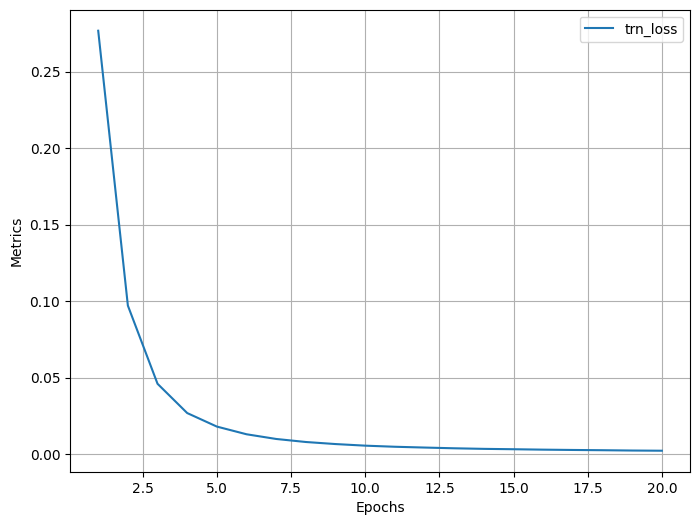

In [ ]:
log.plot_epochs(['trn_loss'])

In [ ]:
split = 'test'

In [ ]:
class ss(Dataset):
    def __init__(self, split):
        self.items = stems(f'/content/drive/MyDrive/gdsc-nu-ml-hackathon-bts-case-competition/{split}/imgs')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        image = read(f'/content/drive/MyDrive/gdsc-nu-ml-hackathon-bts-case-competition/{self.split}/imgs/{self.items[ix]}.jpg', 1)
        return image
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims = list(batch)
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        return ims
test = ss('test')
test_dl = DataLoader(test, batch_size=1, shuffle=True, collate_fn=test.collate_fn)


In [ ]:
items = test.items
items

In [ ]:
test[0].shape

(576, 768, 3)

In [ ]:
subplot_list = []
from torchvision.utils import save_image
# Iterate through the images in test_dl
c=0
for im in test_dl:

    # Pass the image through the model
    _mask = model(im)
    
    # Take the maximum value along the channel dimension
    _, _mask = torch.max(_mask, dim=1)
    
    # Create a subplot of the image and mas
    subplot = _mask.permute(1,2,0).detach().cpu()[:,:,0]
    save_image(subplot.float(), f"{items[c]}.png")
    c+=1

In [ ]:
%cd /content/drive/MyDrive/gdsc-nu-ml-hackathon-bts-case-competition/test

/content/drive/MyDrive/gdsc-nu-ml-hackathon-bts-case-competition/test


In [ ]:
%mkdir mask

In [ ]:
%cd mask

/content/drive/MyDrive/gdsc-nu-ml-hackathon-bts-case-competition/test/mask


In [ ]:

for ix, im in enumerate(iter(test_dl)):
    print(im)
    ID = items[ix]
    im.shape
    _mask = model(im)
    res = _mask.permute(1,2,0).detach().cpu()[:,:,0]
    cv2.imwrite(ID, res) 

tensor[1, 3, 224, 224] n=150528 x∈[-2.118, 1.490] μ=-0.123 σ=0.517 cuda:0

RuntimeError: ignored